In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import seaborn as sns
import torch as th
import matplotlib.pyplot as plt
from aimanager.utils.utils import make_dir
from aimanager.utils.merge import merge_files_by_name

sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})


run = 'baseline2'

folder = f'../../data/training/{run}/train'
merged_folder = f'../../data/training/{run}/merged_dev'
plot_folder = 'plots/baselines2'

make_dir(plot_folder)
make_dir(merged_folder)

/home/mpib/brinkmann/repros/algorithmic-institutions/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def _plot_heatmap(data, x, y, values, normalise=True):
    dfg = data.groupby([x,y])[values].sum()
    dfg = dfg.reset_index()
    if normalise:
        dfg[values] = dfg[values] / dfg.groupby([x])[values].transform('sum')
    cm = dfg.pivot_table(index=x, columns=y, values=values)
    cm = cm.sort_index(ascending=False)
    sns.heatmap(cm)

In [3]:
file_names = ['metrics.parquet', 'confusion_matrix.parquet', 'synthetic_predicitions.parquet']


def get_df(file_name, merged_folder, folder):
    m_file = os.path.join(merged_folder, file_name)
    if not os.path.isfile(m_file):
        df = merge_files_by_name(folder, file_name)
        df.to_parquet(m_file)
        return df
    else:
        return pd.read_parquet(m_file)

metrics_df, confusion_matrix_df, synthethetic_df = (
    get_df(file_name, merged_folder, folder)
    for file_name in file_names
)
metrics_df = metrics_df.reset_index(drop=True)
confusion_matrix_df = confusion_matrix_df.reset_index(drop=True)
synthethetic_df = synthethetic_df.reset_index(drop=True)
metrics_df['shuffle_feature'] = metrics_df['shuffle_feature'].fillna('none')
labels = list(set(metrics_df.columns) - set(['name', 'value', 'cv_split', 'epoch', 'set', 'shuffle_feature', 'strategy']))


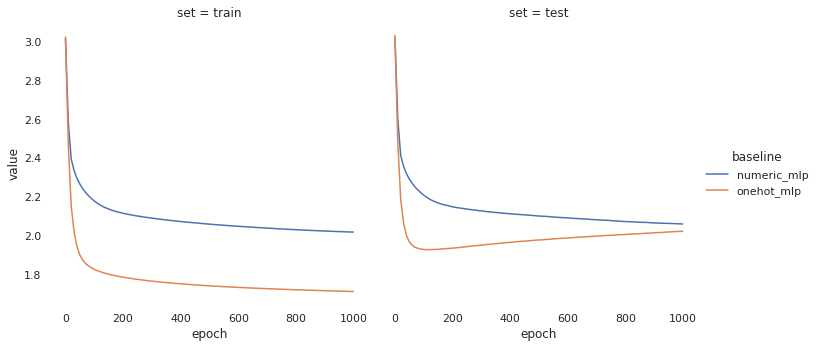

In [4]:
metric_name = 'log_loss'

# selection = best_labels[metric_name].copy()

selection = {
    'name': 'log_loss',
    'shuffle_feature': 'none'
}

focus = ['baseline']

for f in focus:
    if f in selection:
        selection.pop(f)


w1 = pd.concat(
    (metrics_df[k] == v
    for k,v in selection.items()), axis=1
).all(1)

w2 = (
    (metrics_df['name'] == metric_name) 
)

fg = sns.relplot(
    data=metrics_df[w1 & w2].copy(), 
    x='epoch', y='value',
    hue=focus[0] if len(focus) >= 1 else None, 
    style=focus[1] if len(focus) >= 2 else None,  
    col='set', row=focus[2] if len(focus) >= 3 else None, 
    kind='line', ci=None)

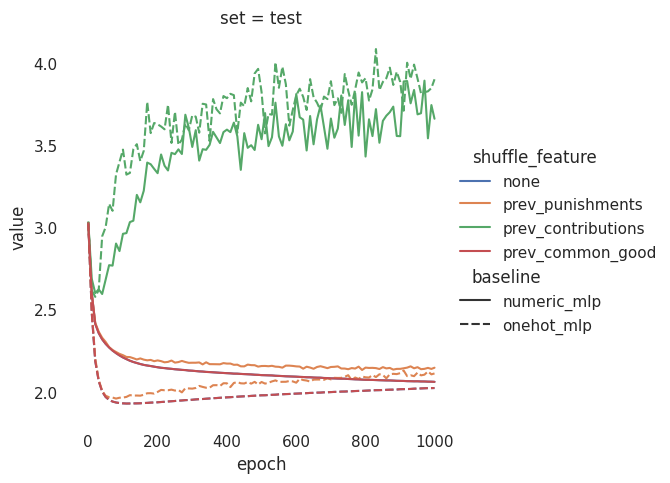

In [5]:
metric_name = 'log_loss'

# selection = best_labels[metric_name].copy()

selection = {
    'name': 'log_loss',
    'set': 'test'
}

focus = ['shuffle_feature', 'baseline']

for f in focus:
    if f in selection:
        selection.pop(f)

df = metrics_df[metrics_df['shuffle_feature'] == 'none']


w1 = pd.concat(
    (metrics_df[k] == v
    for k,v in selection.items()), axis=1
).all(1)

w2 = (
    (metrics_df['name'] == metric_name) 
)

fg = sns.relplot(
    data=metrics_df[w1 & w2].copy(), 
    x='epoch', y='value',
    hue=focus[0] if len(focus) >= 1 else None, 
    style=focus[1] if len(focus) >= 2 else None,  
    col='set', row=focus[2] if len(focus) >= 3 else None, 
    kind='line', ci=None)

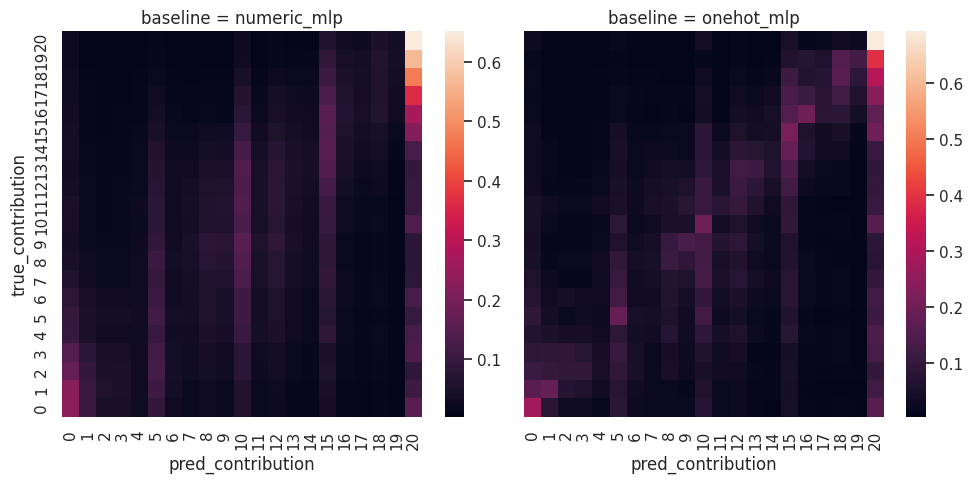

In [6]:
df = confusion_matrix_df.copy()
df['round_number_bin'] = df['round_number'] // 4

w = (
    (df['valid'])
)

df = df[w]

focus_dimensions = ['baseline']


plot_heatmap = lambda data, color: _plot_heatmap(
    data, x='true_contribution',y='pred_contribution', values='proba', normalise=True)

fg = sns.FacetGrid(
    df, col=focus_dimensions[0] if len(focus_dimensions) > 0 else None,
    row=focus_dimensions[1] if len(focus_dimensions) > 1 else None,
    height=5)
fg.map_dataframe(plot_heatmap)

/tmp/ipykernel_21829/1197897100.py:18: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  df = pd.concat([dfc, df]).reset_index()


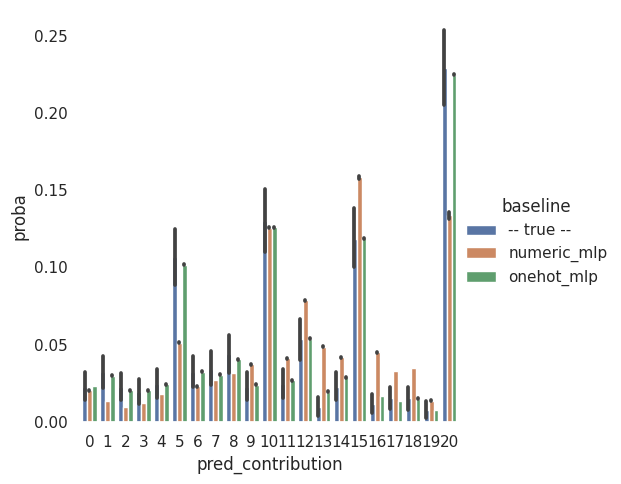

In [7]:
df = confusion_matrix_df.copy()

w = (
    (df['round_number'] == 0) &
    (df['valid'])
)

df = df[w]

focus_dimensions = ['baseline']


dfc = df.copy()

dfc['proba'] = df['pred_contribution'] == df['true_contribution']
dfc[focus_dimensions[0]] = '-- true --'

df = pd.concat([dfc, df]).reset_index()

fg = sns.catplot(
    data=df, x='pred_contribution', y='proba',
    hue=focus_dimensions[0] if len(focus_dimensions) > 0 else None,
    col=focus_dimensions[1] if len(focus_dimensions) > 1 else None,
    row=focus_dimensions[2] if len(focus_dimensions) > 2 else None,
    height=5, kind='bar')

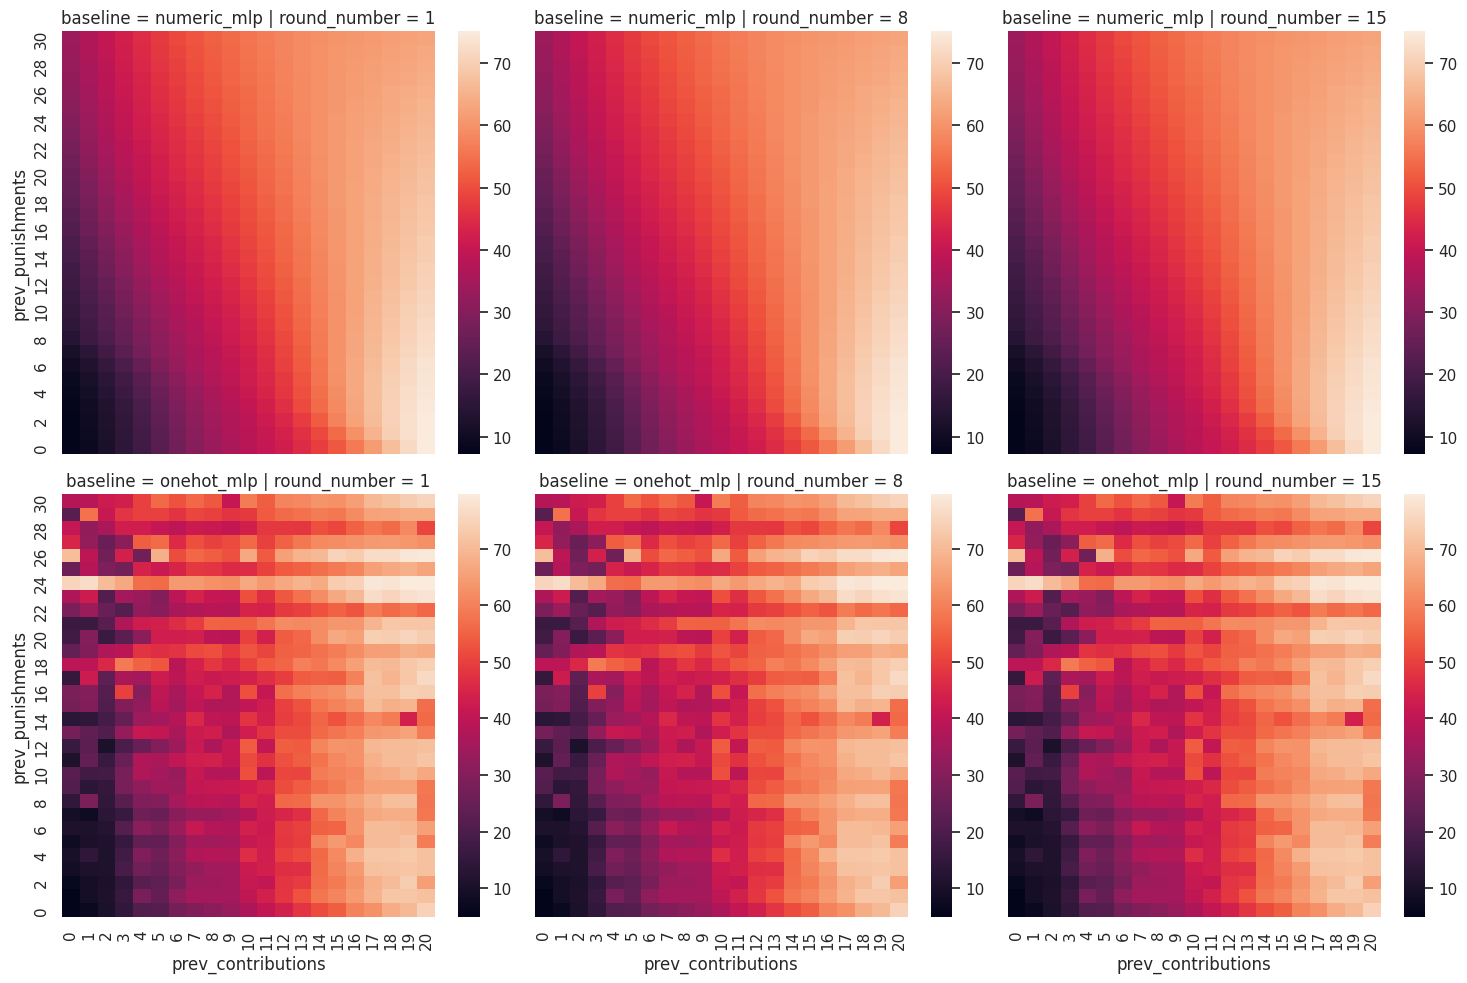

In [10]:
df = synthethetic_df.groupby(['idx','round_number']+labels).agg({'prev_contributions': 'first', 'prev_punishments': 'first','exp_contribution': 'mean'}).reset_index(drop=False)

w = (
    df['round_number'].isin([1,8,15])
)

df = df[w]

focus_dimensions = ['round_number', 'baseline']


plot_heatmap = lambda data, color: _plot_heatmap(
    data, x='prev_punishments',y='prev_contributions', values='exp_contribution', normalise=False)

fg = sns.FacetGrid(
    df, col=focus_dimensions[0] if len(focus_dimensions) > 0 else None,
    row=focus_dimensions[1] if len(focus_dimensions) > 1 else None,
    col_wrap=5 if len(focus_dimensions) < 2 else None,
    height=5)
fg.map_dataframe(plot_heatmap)